# Сверточные нейронные сети в PyTorch

---

## Сверточная нейронная сеть классификации изображений

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

try:  
  from torchsummary import summary
except:
  !pip install -U torchsummary
  from torchsummary import summary

Рассмотрим задачу классификации для датасета Cifar10 - это классический датасет с изображениями, относящимися к 10 классам.
Каждое изображение трех-цветное и имеет размер 32 на 32 пикслея (то есть представляет тензор размером 3х32х32).

Например Cifar10 содержит следующие изображения.

![](https://debuggercafe.com/wp-content/uploads/2019/10/cifar10_plot.png)

Загрузим датасет и проведем его нормализацию

In [ ]:
transform =\
    transforms.Compose([transforms.ToTensor(),
                        transforms.Normalize( 
                            mean = (0.5, 0.5, 0.5), 
                            std  = (0.5, 0.5, 0.5)  )
                       ])

BATCH_SIZE = 4

trainset = torchvision.datasets.CIFAR10(root      = './data', 
                                        train     = True,
                                        download  = True, 
                                        transform = transform)

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size = BATCH_SIZE,
                                          shuffle    = True)

testset = torchvision.datasets.CIFAR10(root      = './data', 
                                       train     = False,
                                       download  = True, 
                                       transform = transform)

testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size = BATCH_SIZE,
                                         shuffle    = False)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Посмотрим на примеры изображений

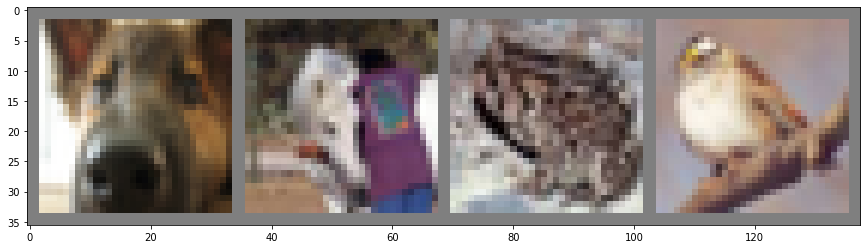

  dog horse  frog  bird


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    
    plt.figure(figsize=(16,4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

batch = trainloader

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Теперь опишем класс сети. Будем использовать классическую сеть LeNet. Данная сеть была предложена в 1998 году и является одной из первых попыток разработки современного deep learning. 

Сеть имеет следующую архитектуру

![](https://miro.medium.com/max/3600/1*-NnRGtEsiLHfNnUCSXoa-Q.png)

Таким образом сеть имеет:
 * входной слой для изображений 32х32 ( в нашем случае 3х32х32),
 * два сверточных слоя, 
 * каждый сверточный слой имеет также макс-пулинг субдискретизацию,
 * слой векторизации карты признаков (приобразования матрицы в вектор путем ее "разворачивания",
 * два полносвязных внутренних слоя,
 * выходной слой - слой классификации с 10 выходами.

Также особенности архитектуры:
* свертка валидная (с уменьшением размера карты признаков на размер ядра - 1)$^*$;
* ядро свертки имеет размер 5х5 (размер ядра = 5);
* макс-пулин выполняется с шагом 2 по тайлам 2х2;
* первый сверточный слой выдает 6 карт признаков 14х14 (после макс-пулинга);
* второй сверточный слой выдает 16 карт признаков 5х5 (после макс-пулинга);
* слой разворачивания принимает 16 карт признаков 5х5 и выдет вектор $1х16*5*5$ (1х400);
* первый полносвязный слой имеет 120 выходов (120 перцептронов);
* второй полносвязный слой имеет на выходе 84 перцептрона.

$^*$Вобщем случае размер выхода свертки можно расчитать как: W=(W−F+2P)/S+1, where W is input size, F is kernel size, S is stride applied, and P is padding. 

**Реализуем сверточную сеть LeNet в виде класса, !Однако, для учебных целей добавим в сеть батч-нормализацию и дроп-ауты**

In [ ]:
class CNNModel(nn.Module):
    
    N_CLASSES = 10  
    
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # convolution
        self.conv1   = nn.Conv2d(in_channels  = 3, 
                                 out_channels = 6, 
                                 kernel_size  = 5)       

        self.conv2   = nn.Conv2d(in_channels  = 6, 
                                 out_channels = 16,
                                 kernel_size  = 5)
        
        self.bn  = nn.BatchNorm2d(16)  
        self.dropout = nn.Dropout(0.1)
        
        self.maxpool = nn.MaxPool2d(kernel_size = 2, 
                                    stride      = 2)
        
        # classification
        self.fc1 = nn.Linear(in_features  = 16 * 5 * 5, 
                             out_features = 120)
        
        self.fc2 = nn.Linear(in_features  = 120, 
                             out_features = 84)
        
        self.fc_out = nn.Linear(in_features = 84, 
                                out_features = self.N_CLASSES)
    
    # specific operation
    def flatten(self, x):
        return x.view(-1, 16 * 5 * 5)
    
    def forward(self, x):
        
        # 1-st layer
        x = self.conv1(x)
        x = torch.relu(x)        
        x = self.maxpool(x)
        x = self.dropout(x)
        
        #2-nd layer
        x = self.conv2(x)         
        x = self.bn(x)        
        x = torch.relu(x)        
        x = self.maxpool(x)

        #flatten
        x = self.flatten(x)
        
        # 1-st fc layer
        x = self.fc1(x)
        x = torch.relu(x)
        
        # 2-nd fc layer
        x = self.fc2(x)
        x = torch.relu(x)
        
        # output layer
        x = self.fc_out(x)
        
        return x#torch.softmax(x, dim=1)

In [ ]:
print(images.shape)

torch.Size([4, 3, 32, 32])


**Опишим настрой**

In [ ]:
LR = 0.001
cnn_net   = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_net.parameters(), lr=LR)


Посмотрим структуру параметров созданной сети

In [ ]:
for name, param in cnn_net.named_parameters():
    print(name, '\t structure =',list(param.size()))

conv1.weight 	 structure = [6, 3, 5, 5]
conv1.bias 	 structure = [6]
conv2.weight 	 structure = [16, 6, 5, 5]
conv2.bias 	 structure = [16]
bn.weight 	 structure = [16]
bn.bias 	 structure = [16]
fc1.weight 	 structure = [120, 400]
fc1.bias 	 structure = [120]
fc2.weight 	 structure = [84, 120]
fc2.bias 	 structure = [84]
fc_out.weight 	 structure = [10, 84]
fc_out.bias 	 structure = [10]


In [ ]:
summary(cnn_net,input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
           Dropout-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
       BatchNorm2d-5           [-1, 16, 10, 10]              32
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
            Linear-8                   [-1, 84]          10,164
            Linear-9                   [-1, 10]             850
Total params: 62,038
Trainable params: 62,038
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.08
Params size (MB): 0.24
Estimated Total Size (MB): 0.33
---------------------------------------------

**Процесс обучения**

In [ ]:
EPOHS = 5

for epoch in range(EPOHS):  # loop over the dataset multiple times
    cnn_net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize        
        outputs = cnn_net(inputs)        
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.894
[1,  4000] loss: 1.706
[1,  6000] loss: 1.613
[1,  8000] loss: 1.547
[1, 10000] loss: 1.502
[1, 12000] loss: 1.478
[2,  2000] loss: 1.432
[2,  4000] loss: 1.392
[2,  6000] loss: 1.385
[2,  8000] loss: 1.340
[2, 10000] loss: 1.351
[2, 12000] loss: 1.325
[3,  2000] loss: 1.281
[3,  4000] loss: 1.275
[3,  6000] loss: 1.289
[3,  8000] loss: 1.263
[3, 10000] loss: 1.246
[3, 12000] loss: 1.255
[4,  2000] loss: 1.217
[4,  4000] loss: 1.226
[4,  6000] loss: 1.201
[4,  8000] loss: 1.205
[4, 10000] loss: 1.205
[4, 12000] loss: 1.188
[5,  2000] loss: 1.143
[5,  4000] loss: 1.150
[5,  6000] loss: 1.161
[5,  8000] loss: 1.145
[5, 10000] loss: 1.166
[5, 12000] loss: 1.165
Finished Training


**Сохраним результат**

In [ ]:
PATH = './cifar_net.pth'
torch.save(cnn_net.state_dict(), PATH)

**Загрузим результат**

In [ ]:
cnn_net = CNNModel()
cnn_net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

**Проверим результат на тесте**

In [ ]:
cnn_net.eval()
dataiter = iter(testloader)
images, labels = dataiter.next()
outputs = cnn_net(images)
print(outputs)

tensor([[-3.2837, -3.9673, -1.5299,  0.7314, -1.7745, -0.0486, -0.6104, -3.3757,
         -0.9014, -3.8526],
        [-0.2538,  3.5094, -5.6621, -6.5749, -7.8627, -6.9011, -7.5081, -8.6892,
          1.7389, -1.0329],
        [ 0.5637,  0.0210, -2.3020, -3.8727, -4.1313, -3.7516, -4.5720, -4.9599,
          1.0423, -1.8073],
        [ 1.0702, -1.3061, -2.3262, -4.3609, -3.3588, -4.0132, -5.9665, -3.8883,
          1.4958, -4.3026]], grad_fn=<AddmmBackward>)


**Приведем результат к более понятному виду**
Каждый номер в выходном тензоре будет класс соответствующий картинке батча

In [ ]:
_, predicted = torch.max(outputs, 1)
print(predicted)

tensor([3, 1, 8, 8])


**Посмотрим, что получилось**

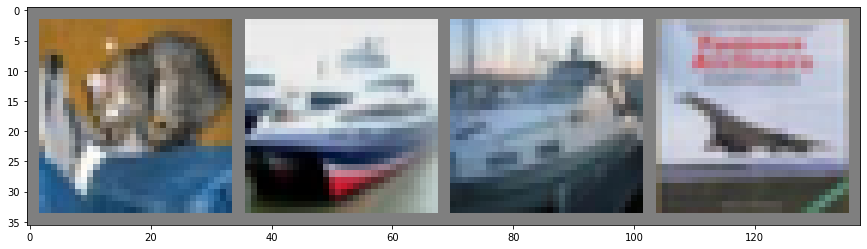

GroundTruth:    cat  ship  ship plane
Predicted :     cat   car  ship  ship


In [ ]:
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
print('Predicted :  ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

**Попробуем посчитать точность как число правильно классифицированных изобаржений к общему числу изображений**

In [ ]:
cnn_net.eval()
correct = 0
total   = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs        = cnn_net(images)
        _, predicted    = torch.max(outputs.data, 1)
        total   += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


**Проведем анализ по каждому классу**

In [ ]:
cnn_net.eval()
class_correct = list(0. for i in range(10))
class_total   = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = cnn_net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 76 %
Accuracy of   car : 83 %
Accuracy of  bird : 52 %
Accuracy of   cat : 30 %
Accuracy of  deer : 49 %
Accuracy of   dog : 43 %
Accuracy of  frog : 67 %
Accuracy of horse : 70 %
Accuracy of  ship : 65 %
Accuracy of truck : 57 %


#### Упражнение 1 
Добавьте к процессу обучения валидацию и добавьте валидационный датасет.

#### Упражнение 2
Улучшьте архитектуру сети путем использования доп.слоев батч-нормализации, дроп-аутов, добавлением слоев и друхи техник.

#### Упражнение 3
Проанализируйте полученные результаты, уберите из обучающей выборки класс с наименьшей точностью, проведите повторное обучение.


- - -

## Оптимизация  обучения модели сверточной сети

**Инициализация весов модели**

In [ ]:
cnn_net = CNNModel()
        
def init_weights(m):
    # for differernt types of layers different initialization could be applied
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)
    
    #same as type(m) == nn.Conv2d, but more correct to use isinstance   
    if isinstance(m, nn.Conv2d):  
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)   

cnn_net.apply(init_weights);

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_net.parameters(), lr=0.001)

Проверим как прошла инициализация для значений смещений

In [ ]:
for name, p in cnn_net.named_parameters():    
    if 'bias' in name:
        print(p,'\n')

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True) 

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True) 

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True) 

Parameter containing:
tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.010

Также посмортим веса для одного из слоев

In [ ]:
print(cnn_net.fc2.weight)

Parameter containing:
tensor([[-0.0049,  0.1568, -0.1938,  ...,  0.0210,  0.2001,  0.0854],
        [ 0.2390,  0.1583,  0.1660,  ...,  0.2324, -0.1878, -0.0452],
        [-0.1908,  0.0208, -0.0475,  ..., -0.1081, -0.0418,  0.0394],
        ...,
        [-0.1874, -0.2636,  0.0752,  ...,  0.1175, -0.1062, -0.1552],
        [ 0.0119, -0.1899, -0.2029,  ...,  0.1675,  0.0606, -0.0726],
        [ 0.2841,  0.1060, -0.0233,  ..., -0.1134, -0.0474,  0.1394]],
       requires_grad=True)


**Регуляризаия**

используем эластическую регуляризацию для весов и для смещения.

In [ ]:
EPOHS = 5
lambda_l1 = 1e-5
lambda_l2 = 1e-3
for epoch in range(EPOHS):  # loop over the dataset multiple times
    cnn_net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize        
        outputs = cnn_net(inputs)        
        loss    = criterion(outputs, labels)
        
        l1_regularization = 0
        l2_regularization = 0
        
        for p in cnn_net.parameters():
            l1_regularization += torch.abs(p).sum()
            l2_regularization += torch.pow(p,2).sum()     

        loss += lambda_l1*l1_regularization + lambda_l2*l2_regularization
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


print('Finished Training')

[1,  2000] loss: 2.244
[1,  4000] loss: 1.931
[1,  6000] loss: 1.801
[1,  8000] loss: 1.731
[1, 10000] loss: 1.704
[1, 12000] loss: 1.662
[2,  2000] loss: 1.621
[2,  4000] loss: 1.619
[2,  6000] loss: 1.598
[2,  8000] loss: 1.592
[2, 10000] loss: 1.588


KeyboardInterrupt: 

посмотрим на результат


In [ ]:
cnn_net.eval()
class_correct = list(0. for i in range(10))
class_total   = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = cnn_net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

#### Упрпажнение 1
Проведите инициализацию смещения слоя батч-нормализации нулями.


#### Упрпажнение 2
1. Исключите из регуляризации слой батч-нормализации.
2. Введите особую процедуру регуляризации для выходного слоя сети
<details>
<summary>Click here for hint</summary>
  Обратится к конкретному слою можно
```
    torch.norm(model.fc1.weight, p=1)
```

- - -